# Introduction to NLP in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences of text or speech.)

Another common term for NLP problems is sequence to sequence problems (seq2seq0).

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ba1c25a4-a5d4-f7fd-62eb-fd44bd700197)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-29 16:14:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-29 16:14:34 (24.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we are going to be using is Kaggel's introduction to NLP dataset (text samples of Tweets as disaster or not disaster).

See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-10-29 16:14:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2021-10-29 16:14:36 (85.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Unzip data
unzip_data('nlp_getting_started.zip')

## Visualizing a text dataset

To visualize our text sample , we first have to read them in, one way to do so would be to use Python: 

But I prefer to get visual staright away.

So another way to do this is to use pandas.

In [6]:
import pandas as pd

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# What does the test dataframe looks like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
# How many example of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [13]:
import random
random_index = random.randint(0, len(train_df) - 5) # create random indexes not higher than the total number samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}, (real disaster)' if target > 0 else '{not real disaster}')
  print(f'Text: \n{text}\n')
  print('-----\n')

{not real disaster}
Text: 
'It looks like a mudslide' 'It's like chewing on rubber' #GBBO ??????

-----

Target: 1, (real disaster)
Text: 
f496D mhtw4fnet

Pakistan says army helicopter has crashed in country's restive northwest  - Fox News

-----

{not real disaster}
Text: 
*screams in 25 different languages*

-----

{not real disaster}
Text: 
Great one time deal on all Avalanche music and with purchase get a Neal Rigga shirt http://t.co/4VIRXkgMpC

-----

{not real disaster}
Text: 
RT @AmznFavorites THE DEVEREAUX DISASTER. 'Exciting scifi #thriller...' http://t.co/Mw9amBgAfq #SciFi #Kindle

-----



### Split data into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [16]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [17]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first thing you have to do before you build a model is , to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenaziation - 
* Embedding - 

### Text Vectorization (tokenization)

In [18]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [20]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # How many words in the vocabluary (automatically add <00V>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?,
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be.,
                                    pad_to_max_tokens=False,
                                    ) 

In [21]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [22]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [23]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15 # max length our sequences will be (e.g. how many words from tweets does a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [24]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [25]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [26]:
# Create a sample sentence and tokenize it
sample_sentence = 'There is a flood in my street!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [27]:
# Choose random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f'original text:\n{random_sentence}\n\nVectorized version:')
text_vectorizer([random_sentence])

original text:
Experts leave lab as Malaysia confirms debris is from #MH370 http://t.co/Ba4pUSvJLN

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 854,  739,  740,   26,  242, 1538,  247,    9,   20,  171,    1,
           0,    0,    0,    0]])>

In [28]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embeddingusing an Embedding Layer

To make our embedding we are going to use Tensorflow's Embedding layers.

The parameters we care most about for our embedding layser:
* `input_dim` - the size of our vocabluary
* `output_dim` - the size of output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_lenght` - length of sequences being passes to the embedding layer

In [29]:
from tensorflow.keras import layers

In [30]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length)

In [31]:
embedding

In [32]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@POTUS Maybe we should call Israel and tell them we're sorry are Pres has sold them down the river to annihilation.

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03510374, -0.04911024,  0.04326497, ..., -0.04462011,
         -0.02267363,  0.02826666],
        [-0.0113929 , -0.04855978,  0.00136683, ..., -0.01518558,
         -0.0164919 , -0.00244705],
        [ 0.02221867, -0.04924427, -0.02847658, ...,  0.02405796,
         -0.0190712 , -0.03433985],
        ...,
        [-0.03770427, -0.04827994,  0.01048982, ..., -0.02398826,
         -0.02955105,  0.04995723],
        [-0.01406193, -0.04578102,  0.03868637, ...,  0.03587892,
         -0.0440945 ,  0.01958803],
        [ 0.03399695, -0.04332596, -0.02197155, ..., -0.02209476,
         -0.01862321,  0.02858276]]], dtype=float32)>

In [33]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03510374, -0.04911024,  0.04326497,  0.00230486,  0.01774741,
         0.03590374,  0.00930095, -0.01513653, -0.02001897,  0.03446228,
        -0.03409559,  0.0405475 , -0.03351317, -0.03099904, -0.01202093,
        -0.0344672 ,  0.01464558, -0.04058896, -0.01992592,  0.04770898,
         0.00762045,  0.03123175,  0.01543567, -0.04710014, -0.0156842 ,
         0.00423759, -0.0062948 ,  0.01758802, -0.04996865, -0.02427023,
         0.026454  ,  0.04398043,  0.02941961, -0.01336155, -0.01096081,
         0.00088943, -0.00769547, -0.04170265, -0.01819636, -0.00703277,
        -0.01901602, -0.01295152,  0.0001219 , -0.03670074,  0.04896119,
         0.02750513,  0.01819675,  0.02377709, -0.04140974, -0.00652392,
        -0.02218908,  0.02023462,  0.00969293,  0.02829386, -0.03249674,
        -0.0296454 , -0.00732616, -0.00466435, -0.03054038, -0.02897322,
         0.03433793,  0.0169188 , -0.0247291 , -0.00268131, -0.00263919,
  

## Modeling a text dataset (running a series of experiments)

No we have got a way to turn our text sequences into number, it's time to start building a series of modelling experiments.

We will start with a baseline and move on from 

* Model 0: Naiave Bayes (baseline), this is from Sklearn ML
map:

* Model 1: 

* Model 2: LSTM (RNN)

* Model 3: GRU model (RNN)

* Model 4: Bidirectional - LSTM model(RNN)

* Model 5: 1D Convolutional Neural Network (CNN)

* Model 6: TensorFlow HUb Pretrained Feature Extractor (using tranfer learning for NLP)

* Model 7: Same as model 6 with 10% of training data


How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a Model
*

### Model 9: Getting a baseline

To create our baseline we will use Sklearn's Multinomial Naive Bayes using the TD-IDF farmula to convert our words into numbers.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [35]:
# Create tokenization and modeling pipeline
model_0 = Pipeline([
  ('tfidf', TfidfVectorizer()), # convert words to numbers
  ('clf', MultinomialNB()) # model the text            
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [36]:
# Evalutate the model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Our baseline mocel achieves an accurac of: {baseline_score*100:.2f}%')

Our baseline mocel achieves an accurac of: 79.27%


In [37]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [38]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evalutaion function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however , this will be combersome and easily be fixed with a function.

Let's create one to compare our model's predictions with the truth lables using the following
* Accuracy
* Precision
* Recall
* F1-score

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [40]:
def calculate_results(y_true, y_pred):

  # Calcuate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}

  return model_results               


In [41]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [42]:
from helper_functions import calculate_results

In [43]:
print(calculate_results(y_true=val_labels,
                        y_pred=baseline_preds))

{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 1: A simple dense model

In [44]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [45]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-d string
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')

In [46]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [48]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20211029-161444
Epoch 1/5
215/215 [==============================] - 5s 9ms/step - loss: 0.6133 - accuracy: 0.6958 - val_loss: 0.5390 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4423 - accuracy: 0.8174 - val_loss: 0.4680 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3472 - accuracy: 0.8612 - val_loss: 0.4588 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2851 - accuracy: 0.8891 - val_loss: 0.4674 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2385 - accuracy: 0.9120 - val_loss: 0.4832 - val_accuracy: 0.7900


In [49]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4832 - accuracy: 0.7900


[0.4832019507884979, 0.7900262475013733]

In [50]:
# Make some prediction and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [51]:
model_1_pred_probs[0]

array([0.31535906], dtype=float32)

In [52]:
model_1_pred_probs[:10]

array([[0.31535906],
       [0.76769036],
       [0.99748826],
       [0.10697991],
       [0.11283472],
       [0.93054396],
       [0.88725823],
       [0.9929958 ],
       [0.9635225 ],
       [0.2483562 ]], dtype=float32)

In [53]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [54]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [55]:
# Calcualte our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.00262467191601,
 'f1': 0.7861489606524887,
 'precision': 0.7980691136385264,
 'recall': 0.7900262467191601}

In [56]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [57]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [58]:

# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [59]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Get the weight matrix in embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epocsh)
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[ 0.00188457,  0.0007288 ,  0.03701846, ...,  0.01333733,
        -0.01067189, -0.01046082],
       [ 0.02149376,  0.05278736,  0.05727471, ...,  0.05126861,
         0.03807554,  0.01160077],
       [-0.0011326 , -0.00043863, -0.00192639, ...,  0.00508604,
         0.00828655,  0.00654857],
       ...,
       [ 0.01451064, -0.00495392, -0.03484436, ...,  0.04900337,
        -0.03435735,  0.03123761],
       [-0.010086  ,  0.03421369,  0.01899315, ...,  0.06980158,
        -0.00459915, -0.0843445 ],
       [-0.05918834,  0.10847693,  0.08009945, ...,  0.0409406 ,
        -0.0933672 , -0.02224226]], dtype=float32)

In [62]:
print(embed_weights.shape) # same size as vocab and embedding dim (output_dim of our embedding layer)

(10000, 128)


In [63]:
embed_weights

array([[ 0.00188457,  0.0007288 ,  0.03701846, ...,  0.01333733,
        -0.01067189, -0.01046082],
       [ 0.02149376,  0.05278736,  0.05727471, ...,  0.05126861,
         0.03807554,  0.01160077],
       [-0.0011326 , -0.00043863, -0.00192639, ...,  0.00508604,
         0.00828655,  0.00654857],
       ...,
       [ 0.01451064, -0.00495392, -0.03484436, ...,  0.04900337,
        -0.03435735,  0.03123761],
       [-0.010086  ,  0.03421369,  0.01899315, ...,  0.06980158,
        -0.00459915, -0.0843445 ],
       [-0.05918834,  0.10847693,  0.08009945, ...,  0.0409406 ,
        -0.0933672 , -0.02224226]], dtype=float32)

Now we have got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a 

In [64]:
import io

In [65]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [66]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premis of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> **Resources**: If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's lectures : https://www.youtube.com/watch?v=5tvmMX8r_OM&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI

- Chris Ola's intro ot LSTMs: 

- Andrej Karpathy's the unreasonable effectivenss of recurrent neural networks:


### Model 2: LSTM

LSTM - Long Short Term Memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Ouput (label probability)

In [67]:
# Create an LSTM model

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # When you are stacking RNN cells, you need to return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs =layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [68]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [70]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211029-161519
Epoch 1/5
215/215 [==============================] - 8s 15ms/step - loss: 0.2205 - accuracy: 0.9193 - val_loss: 0.6083 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1570 - accuracy: 0.9416 - val_loss: 0.5523 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1311 - accuracy: 0.9511 - val_loss: 0.6572 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1047 - accuracy: 0.9612 - val_loss: 0.7779 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0825 - accuracy: 0.9699 - val_loss: 1.0492 - val_accuracy: 0.7730


In [71]:
# Make predictions with LSTM Model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.2913057e-01],
       [8.2247239e-01],
       [9.9978954e-01],
       [2.6456989e-02],
       [3.4691489e-04],
       [9.9939334e-01],
       [9.4274437e-01],
       [9.9989033e-01],
       [9.9982387e-01],
       [5.7334840e-01]], dtype=float32)

In [72]:
# Convert model 2 pred probs to labels
model_2_pred = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [73]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_pred)

model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7718716556605149,
 'precision': 0.7730528656214299,
 'recall': 0.7729658792650919}

In [74]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit:

The GRU cells has similar features to an LSTM cell but has less parameters.

In [75]:
# Build an RNN using the GRU cells
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
x = layers.GRU(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.LSTM(42, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [76]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,342,273
Trainable params: 1,342,273
Non-trainable params: 0
_____________________________________________

In [77]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [78]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211029-161543
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.1384 - accuracy: 0.9467 - val_loss: 0.7917 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0810 - accuracy: 0.9688 - val_loss: 0.8497 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0709 - accuracy: 0.9726 - val_loss: 1.0548 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0592 - accuracy: 0.9764 - val_loss: 0.9068 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0569 - accuracy: 0.9774 - val_loss: 1.2985 - val_accuracy: 0.7730


In [79]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[9.9365465e-02],
       [7.2484952e-01],
       [9.9990940e-01],
       [1.9426813e-02],
       [8.7573622e-05],
       [9.9985588e-01],
       [6.4992219e-01],
       [9.9994493e-01],
       [9.9993336e-01],
       [9.3588704e-01]], dtype=float32)

In [80]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [81]:
# Calcualte model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.29658792650919,
 'f1': 0.7709704727215051,
 'precision': 0.7745161732477092,
 'recall': 0.7729658792650919}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however bidirectional RNN's goes from right to left and also left to right.

In [82]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [83]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [85]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211029-161606
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.1067 - accuracy: 0.9688 - val_loss: 0.9586 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0514 - accuracy: 0.9771 - val_loss: 1.1988 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0482 - accuracy: 0.9787 - val_loss: 1.3223 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0441 - accuracy: 0.9806 - val_loss: 1.3695 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0409 - accuracy: 0.9812 - val_loss: 1.4816 - val_accuracy: 0.7625


In [86]:
# Make predictionas with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.0910243e-03],
       [6.7960870e-01],
       [9.9999058e-01],
       [1.3495059e-01],
       [2.1462298e-05],
       [9.9940276e-01],
       [2.9459098e-01],
       [9.9999654e-01],
       [9.9999368e-01],
       [9.9925405e-01]], dtype=float32)

In [87]:
# Convert pred probs to pred labels 
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [88]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'f1': 0.7612168110136286,
 'precision': 0.7625326572242482,
 'recall': 0.7624671916010499}

In [89]:
model_3_results

{'accuracy': 77.29658792650919,
 'f1': 0.7709704727215051,
 'precision': 0.7745161732477092,
 'recall': 0.7729658792650919}

## Convolutional Neural Networks for Text (and other types of sequences)

We have used CNNs for images but images are typically 2D (height x Width)... however, our text data is 1D.

Previously we have used Conv2D for our image data but now we are going to use Conv1D.

The typical structure of a Conv1D model for sequences , in our case , text:

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + Pooling) -> Output (class probabilities)```

### Model 5: Conv1D

For different explainations of parameters see:
* https://poloclub.github.io/cnn-explainer/
* Difference between `same` and `valid` padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=VALID%20%3A%20Don't%20apply%20any,filter%20and%20stride%20you%20specified.

In [90]:
# Test out our embeddingl layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentences'])) # turn target sequences into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [91]:
embedding_test = embedding(text_vectorizer(['this is a test sentences'])) # turn target sequences into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu',
                        padding='same')
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [92]:
# embedding_test

In [93]:
# conv_1d_output

In [94]:
# max_pool_output

In [95]:
# Create a 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation='relu)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [96]:
# Get a summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [97]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20211029-161652
Epoch 1/5
215/215 [==============================] - 4s 10ms/step - loss: 0.1203 - accuracy: 0.9607 - val_loss: 0.9486 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0737 - accuracy: 0.9731 - val_loss: 1.0660 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0597 - accuracy: 0.9762 - val_loss: 1.2299 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0546 - accuracy: 0.9780 - val_loss: 1.2362 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0516 - accuracy: 0.9797 - val_loss: 1.1980 - val_accuracy: 0.7572


In [98]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[3.7358350e-01],
       [6.3286966e-01],
       [9.9993813e-01],
       [6.3219249e-02],
       [1.1749029e-07],
       [9.9582940e-01],
       [9.9288815e-01],
       [9.9998713e-01],
       [9.9999964e-01],
       [8.5343593e-01]], dtype=float32)

In [99]:
# Convert model_5 pred prob to label
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [100]:
# Evaluate model_5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.7217847769029,
 'f1': 0.7561520587599432,
 'precision': 0.7570143518442038,
 'recall': 0.7572178477690289}

In [101]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we have built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence.

Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [102]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns into numbers'])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01602836  0.01068851  0.02425466 -0.01405769  0.01434424  0.08292626
  0.01963372  0.06160138 -0.003527   -0.01216414  0.00978648 -0.01248498
  0.01232344  0.09748449  0.06141113 -0.03728351  0.01860886 -0.04669853
  0.00413913 -0.06363907 -0.02469897  0.02713691  0.02284443 -0.00210022
 -0.00630595 -0.03964957  0.0222041   0.00115077 -0.03132179  0.00119526
 -0.04012548  0.04561896 -0.01530596 -0.00175918  0.02173134 -0.08450425
  0.03340028  0.04604552 -0.02480248 -0.08681665  0.00702695 -0.00770479
 -0.0143454   0.07814161 -0.10676058 -0.05152997 -0.00858156 -0.03232232
 -0.03871096  0.0258147 ], shape=(50,), dtype=float32)


In [103]:
embed_samples[0].shape

TensorShape([512])

In [104]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [105]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(1, activation='sigmoid')                               
], name='model_6_USE')

In [106]:
# compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [107]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211029-161728
Epoch 1/5
215/215 [==============================] - 10s 32ms/step - loss: 0.6508 - accuracy: 0.7177 - val_loss: 0.6138 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.5827 - accuracy: 0.7916 - val_loss: 0.5631 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.5392 - accuracy: 0.7978 - val_loss: 0.5311 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.5100 - accuracy: 0.8006 - val_loss: 0.5095 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4898 - accuracy: 0.7994 - val_loss: 0.4949 - val_accuracy: 0.7913


In [108]:
# Make prediction with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.37169012],
       [0.6727368 ],
       [0.8604765 ],
       [0.3447049 ],
       [0.6317307 ],
       [0.72644806],
       [0.8297757 ],
       [0.8458445 ],
       [0.7503219 ],
       [0.21294305]], dtype=float32)

In [109]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [110]:
# Calcualte model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 79.13385826771653,
 'f1': 0.790332908959664,
 'precision': 0.791659328034437,
 'recall': 0.7913385826771654}

In [111]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [112]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')                               
], name='model_6_USE')

In [113]:
# compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [114]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211029-161756
Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.5045 - accuracy: 0.7832 - val_loss: 0.4502 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4148 - accuracy: 0.8151 - val_loss: 0.4431 - val_accuracy: 0.8031
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4012 - accuracy: 0.8216 - val_loss: 0.4329 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3929 - accuracy: 0.8276 - val_loss: 0.4277 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3847 - accuracy: 0.8269 - val_loss: 0.4361 - val_accuracy: 0.8110


In [115]:
# Make prediction with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.15802753],
       [0.7873265 ],
       [0.9838148 ],
       [0.18852523],
       [0.71873957],
       [0.6635775 ],
       [0.974392  ],
       [0.9728908 ],
       [0.9200188 ],
       [0.08937719]], dtype=float32)

In [116]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
# Calcualte model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.8084939790481314,
 'precision': 0.8164847669357785,
 'recall': 0.8110236220472441}

In [118]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [119]:
len(train_sentences)

6851

In [120]:
len(train_df_shuffled)

7613

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's repliccate `model_6` except we will train it on 10% of the data.

In [121]:
## NOTE: Making data split like below leads to data leakage (model_7 trained on 10% data, outperformes model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET.

# Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

**Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of the data outperforming the same model trained on 100% of data) trust you gut and go back through to find where the error may lie.

In [122]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]

train_labels_10_percent = train_labels[:train_10_percent_split]

In [123]:
# Check the number of each label in our subset of data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [124]:
# Check the number of targets in our subset of data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [126]:
# Check the number of targets in our subset of data
# train_10_percent['target'].value_counts()

In [127]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model same as a previous model you heave created , you can use the `tf.keras.models.clone_model()` method.

In [128]:
# Let's build a model same as mode_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get a summary (will same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [129]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentece_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentece_encoder_10_percent_correct_split/20211029-161905
Epoch 1/5
22/22 [==============================] - 6s 172ms/step - loss: 0.6646 - accuracy: 0.7066 - val_loss: 0.6410 - val_accuracy: 0.7546
Epoch 2/5
22/22 [==============================] - 1s 49ms/step - loss: 0.5903 - accuracy: 0.8102 - val_loss: 0.5838 - val_accuracy: 0.7677
Epoch 3/5
22/22 [==============================] - 1s 36ms/step - loss: 0.5172 - accuracy: 0.8161 - val_loss: 0.5298 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 48ms/step - loss: 0.4580 - accuracy: 0.8234 - val_loss: 0.5018 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 1s 48ms/step - loss: 0.4186 - accuracy: 0.8394 - val_loss: 0.4863 - val_accuracy: 0.7808


In [130]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.19502726],
       [0.63293195],
       [0.9054157 ],
       [0.36068138],
       [0.5621873 ],
       [0.72232103],
       [0.8851753 ],
       [0.8207082 ],
       [0.84301245],
       [0.14370589]], dtype=float32)

In [131]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [132]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'f1': 0.7794817733933848,
 'precision': 0.781486692298758,
 'recall': 0.7808398950131233}

In [133]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Comparing the performance of each of our models

In [134]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_lstm': model_2_results,
                                  '3_gru': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv1d': model_5_results,
                                  '6_tf_hub_use_encoder': model_6_results,
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()

In [135]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.790026,0.798069,0.790026,0.786149
2_lstm,0.772966,0.773053,0.772966,0.771872
3_gru,0.772966,0.774516,0.772966,0.770970
4_bidirectional,0.762467,0.762533,0.762467,0.761217
5_conv1d,0.757218,0.757014,0.757218,0.756152
6_tf_hub_use_encoder,0.811024,0.816485,0.811024,0.808494
7_tf_hub_use_encoder_10_percent,0.780840,0.781487,0.780840,0.779482


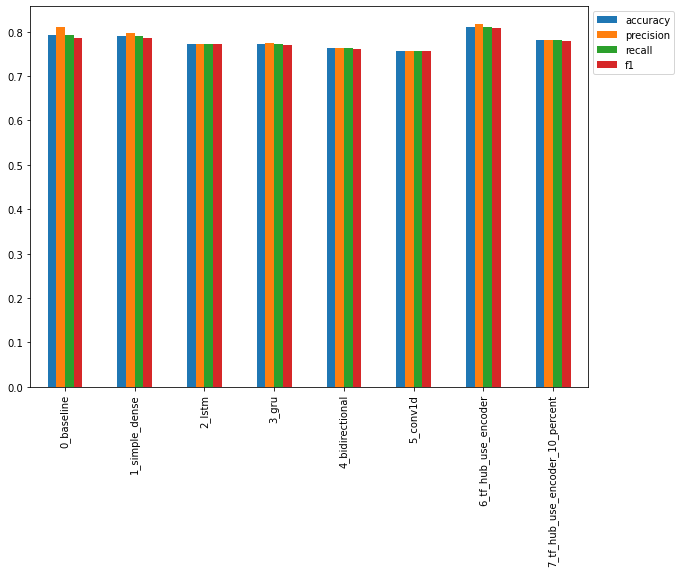

In [136]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

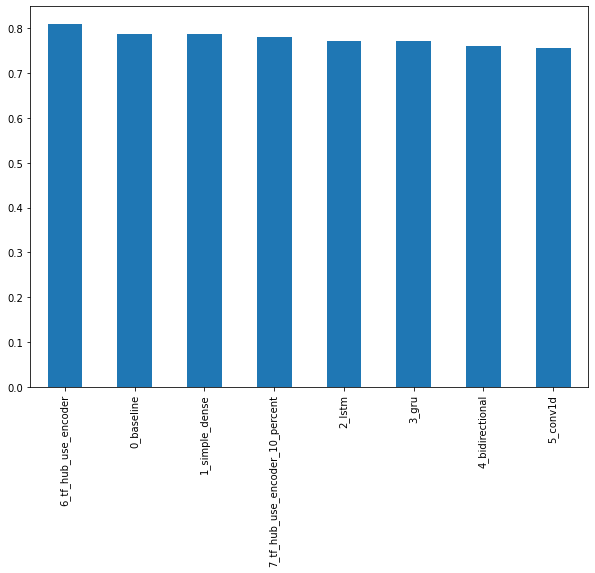

In [137]:
# Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));


 ## Uploading our model training logs to TensorBoard.dev
 
 We can further insepct our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [138]:
# View TensorBoard logs of Transfer Learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot # exit the uploader once uploading is finished

2021-10-29 16:19:20.974154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:19:21.000511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:19:21.001281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Po

Now we have ran the cell above, my modelling experiments are visible on TensorBoard.dev: https://tensorboard.dev/experiment/YEaJ6IqDQ26WMiKohg1mYA/

**Resource:** TensorBoard is great for quickly tracking experiments but for longer scale experiments and a whole bunch more tracking options, check out Weights and Biases: https://wandb.ai/site

In [139]:
# To see the list of experiments you have done in TensorBoard
!tensorboard dev list

2021-10-29 16:20:51.083428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:20:51.092737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:20:51.093327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/nPyzSwveRhqrtxXeDkZKRw/
	Name                 NLP Modelling Experiments ZTM TF Course Video
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset
	Id                   nPyzSwveRhqrtxXeDkZKRw
	Created              2021-10-29 16:20:

In [140]:
# To delete an experiment from TensorBoard
# !tensorboard dev delete --experiment_id Eacboed3RbKPWIGcXe1Z6g

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The `HDF5` format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [141]:
# Save TF Hub sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [142]:
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [143]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4361 - accuracy: 0.8110


[0.4361002743244171, 0.8110235929489136]

In [144]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.8084939790481314,
 'precision': 0.8164847669357785,
 'recall': 0.8110236220472441}

Now let's save to the `SavedModel` format..

In [145]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save('model_6_SavedModel_format')

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [146]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [147]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4361 - accuracy: 0.8110


[0.4361002743244171, 0.8110235929489136]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which one is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probabiliy of 0.999 (really close to 1) and vice versa.

In [148]:
# 
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-10-29 16:21:28--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  42.2MB/s    in 9.0s    

2021-10-29 16:21:37 (102 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.inde

In [149]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [150]:
# Make predictions with the laoded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [151]:
# Create a DataFrame with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [152]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10] # these are false positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [153]:
most_wrong.tail() # these are false negative.

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target lables...
* 0 = not disaster
* 1 = disaster

In [154]:
# Check the false positives (model predicted 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text: \n{text}\n')
  print('-----\n') 

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text: 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text: 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text: 
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text: 
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Target: 0, Pred: 1.0, Prob: 0.8272134065628052
Text: 
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text: 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the 

In [156]:
# Check the false negatives (model predicted 0 when should have been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
  print(f'Text: \n{text}\n')
  print('-----\n') 

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text: 
@DavidVonderhaar At least you were sincere ??

-----

Target: 1, Pred: 0.0, Prob: 0.05507582053542137
Text: 
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, Pred: 0.0, Prob: 0.05460336431860924
Text: 
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text: 
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text: 
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text: 
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

Target: 1, Pred: 0

In [157]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making predictions on the test dataset

In [158]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text:\n {test_sample}\n')
  print('----------\n')

Pred: 1, Prob: 0.5718098878860474
Text:
 Disaster [Chapter 27] https://t.co/EAsxT3y84R http://t.co/CjUFunsDKg

----------

Pred: 0, Prob: 0.0653027892112732
Text:
 Awh damn  I just realized yall gone flooding my TL with school shit and Ima be like .. ??

----------

Pred: 0, Prob: 0.05317346751689911
Text:
 Wrecked today got my hattrick ????

----------

Pred: 0, Prob: 0.25983625650405884
Text:
 'There is no victory at bargain basement prices.' Dwight David Eisenhower

----------

Pred: 1, Prob: 0.6378052830696106
Text:
 The U.S. will experience an economic meltdown similar to the early 2000s mortgage shit show due to student loans. You heard it here first ????

----------

Pred: 0, Prob: 0.08839381486177444
Text:
 It seems that we are inundated with ideas for large #weddings. Small intimate weddings are often not highlighted... http://t.co/Jshxfvllly

----------

Pred: 1, Prob: 0.7930663228034973
Text:
 #Fracking #Ecocide Eyewitness to Extreme Weather: 11 Social Media Posts that Show 

## Your: challenge... predicting on tweets form the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model
Is that Tweet a disaster or not disaster (according to the model)? is the model right or wrong?

## The speed/score tradeoff

In [162]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """

  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [163]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.3940217929998653, 0.0005170889671914242)

In [164]:
 # Calculate our basline model times per pred
 baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
 baseline_total_pred_time, baseline_time_per_pred

(0.026383011000234546, 3.4623374016055835e-05)

In [165]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

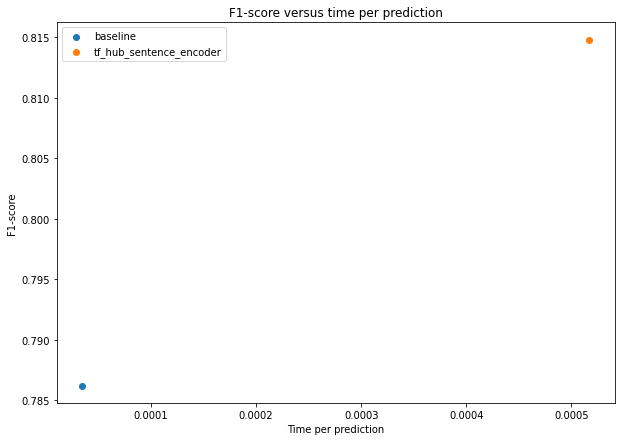

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score versus time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1-score');